# Explore openSMILE

This notebook will explore the [openSMILE](https://audeering.github.io/opensmile-python/) Python interface to extract vocal features from audio. To run the notebook the `opensmile` package needs to be installed: Run a command prompt as administrator and then enter `pip install opensmile`.

When FFmpeg is not installed, openSMILE expects audio file in mono PCM `.wav` format. It extracts different pre-defined feature sets (see this [link](https://coder.social/audeering/opensmile-python) for a comparison) that can be applied on three different levels: Low-level descriptors, functionals, and low-level descriptor deltas. It is also possible to supply a custom configuration file for feature extraction.

In [18]:
import opensmile
import pandas as pd
import matplotlib.pyplot as plt

## Single Speaker

As a test case for a single speaker, a part of the victory speech by the current president of the United States Joe Biden will be used ([link](https://www.englishspeecheschannel.com/english-speeches/joe-biden-speech/) to full speech). This audio file is located at `/audio`.

In [5]:
extractor = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors
)

In [6]:
extractor.feature_names

['Loudness_sma3',
 'alphaRatio_sma3',
 'hammarbergIndex_sma3',
 'slope0-500_sma3',
 'slope500-1500_sma3',
 'spectralFlux_sma3',
 'mfcc1_sma3',
 'mfcc2_sma3',
 'mfcc3_sma3',
 'mfcc4_sma3',
 'F0semitoneFrom27.5Hz_sma3nz',
 'jitterLocal_sma3nz',
 'shimmerLocaldB_sma3nz',
 'HNRdBACF_sma3nz',
 'logRelF0-H1-H2_sma3nz',
 'logRelF0-H1-A3_sma3nz',
 'F1frequency_sma3nz',
 'F1bandwidth_sma3nz',
 'F1amplitudeLogRelF0_sma3nz',
 'F2frequency_sma3nz',
 'F2bandwidth_sma3nz',
 'F2amplitudeLogRelF0_sma3nz',
 'F3frequency_sma3nz',
 'F3bandwidth_sma3nz',
 'F3amplitudeLogRelF0_sma3nz']

In [3]:
features_single_df = extractor.process_file("audio/test_audio_single.wav")

In [7]:
print(features_single_df["F0semitoneFrom27.5Hz_sma3nz"])

file                         start                   end                   
audio/test_audio_single.wav  0 days 00:00:00         0 days 00:00:00.020000    37.153427
                             0 days 00:00:00.010000  0 days 00:00:00.030000    37.187588
                             0 days 00:00:00.020000  0 days 00:00:00.040000    37.305878
                             0 days 00:00:00.030000  0 days 00:00:00.050000    37.563763
                             0 days 00:00:00.040000  0 days 00:00:00.060000    37.740345
                                                                                 ...    
                             0 days 00:00:29.910000  0 days 00:00:29.930000    25.055805
                             0 days 00:00:29.920000  0 days 00:00:29.940000    25.066771
                             0 days 00:00:29.930000  0 days 00:00:29.950000    25.088697
                             0 days 00:00:29.940000  0 days 00:00:29.960000    23.766296
                             0 day

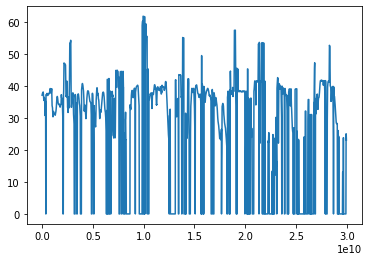

In [22]:
plot_single_df = features_single_df.reset_index()

x = pd.to_timedelta(plot_single_df["start"])
y = plot_single_df["F0semitoneFrom27.5Hz_sma3nz"]

plt.plot(x, y)
plt.show()

## Multiple speakers

As a test case for multiple speakers, a part of a presidential debate in the United States 2020  will be used ([link](https://www.englishspeecheschannel.com/english-speeches/us-presidential-debates-2020/) to full speech). The audio file is located at `/audio`.

In [23]:
features_multi_df = extractor.process_file("audio/test_audio_multi.wav")

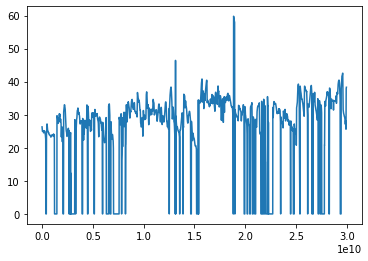

In [24]:
plot_multi_df = features_multi_df.reset_index()

x = pd.to_timedelta(plot_multi_df["start"])
y = plot_multi_df["F0semitoneFrom27.5Hz_sma3nz"]

plt.plot(x, y)
plt.show()